# Run the MNE BIDS Pipeline

Instead of the manual implementation using MNE, for this project the MNE-BIDS-Pipeline is chosen.
The advantages of the pipeline include the clear sequential structure, the reproducability, and caching, as the authors write on [MNE-BIDS-Pipeline overview](https://mne.tools/mne-bids-pipeline/stable/features/overview.html).

On the one hand, the structure introduces additional effort in some steps like customisations, on the other hand, it can help new users of EEG signal processing with their first steps.
Additionally, the reproducability helps in the collaboration over different operating systems.
And in the development, the caching helps to reduce the delay between subsequent changes due to tests running the pipeline.

These reasons led to the use of MNE-BIDS-Pipeline.
Therefore, this kind of implementation is given below in this notebook.

## Steps for Running this Notebook

1. Clone the Git repository of this project. (Since the Notebook is available, this step should be fulfilled.)
2. Set the number of parallel jobs to a value matching RAM (≤ 1 GB per job) and CPU core number (≤ 1 job per core) of the used system. More jobs allow for shorter total execution time.
3. Run preparatory notebook `prepare_data.ipynb` to install dependencies, download, and patch the dataset.
4. Run the pipeline with checkups by running this notebook.

## Header: Load Modules, Set and Load Parameters, Define Functions
Prior to running the main steps of the pipeline, multiple steps need to be performed:

- Load modules:
  Load modules needed for all (e. g. MNE BIDS pipeline), or few (e. g. `typing`) pipeline steps. Load custom modules (e. g. `ica_helpers`)
- Set and load parameters:
  Set the relative (or absolute) path to the pipeline configuration, and load the configuration from the file.

In [1]:
# import basic EEG manipulation and analysis modules
import mne_bids_pipeline
import pandas
import pandas as pd

# import function to load configuration from file
from mne_bids_pipeline._config_import import _import_config as getConfig

# allow for accessing the command line within Python
import sys

In [2]:
# allow for checkup plots based on data stored in files
import mne # module for e.g. loading raw, or epoched signals from file
import matplotlib
import matplotlib.pyplot as plt # plotting module
%matplotlib inline


In [3]:
# set the file path of the main configuration file
config_path = "./mne-bids/config/mne-bids-pipeline.py"

In [4]:
# define a function which gets used in application of the ICA results to the raw data
import src.tools.ica_helpers as ih

In [5]:
# custom module for plotting
import src.tools.plot_power as pp
import src.tools.cmd as cmd

In [6]:
# Custom command line output
import src.tools.logtools as log

In order to speed up testing, we can enable and disable each individual pipeline step. STEPS_TO_RUN overrides this mechanic, forcing a full run of the pipeline.

In [7]:
# set steps to be run in this running iteration
# This helps to reduce the duration of runs in the project development.
STEPS_TO_RUN = {
    "init": False,
    "preprocessing/_01_data_quality": False,
    "preprocessing/_02_head_pos": False,
    "preprocessing/_03_maxfilter": False,
    "preprocessing/_04_frequency_filter": False,
    "preprocessing/_05_make_epochs": False,
    "preprocessing/_06a_run_ica": False,
    "preprocessing_apply_icalabel": False,
    "preprocessing/_07a_apply_ica": False,
    "preprocessing/_08_ptp_reject": False,
    "sensor": False,
    "source": False,
}

RUN_ALL_STEPS = True

In [8]:
if RUN_ALL_STEPS:
    for step in STEPS_TO_RUN:
        STEPS_TO_RUN[step] = True

## Pipeline

Start the pipeline running these steps:

- `preprocessing/_01_data_quality`
- `preprocessing/_04_frequency_filter`
- `preprocessing/_05_make_epochs`
- `preprocessing/_06a_run_ica`, ica labelling, `preprocessing/_07a_apply_ica`
- `preprocessing/_08_ptp_reject`
- `sensor`
- `source`

Each of the steps contains one or more checkups for validating the results of the step.

Since the step names of MNE BIDS pipeline were changed after the start of this notebooks creation, the step names should get updated for use with another module version.
The simplest version could be to run all pre-processing by running `preprocessing` instead of the minor steps `preprocessing/_0*_*`.

### Initial Setup

First, the selected pipeline configuration gets loaded.
Few of its entries get printed as checkup.

Then, the initial preparations for running the pipeline get started: configuration loading and directory creation.
This also is followed by a checkup.

In [9]:
# load configured settings from file
cfg = getConfig(
    config_path=config_path
)

In [10]:
# checkup: print config contents
print(
    "study name:\t\t", cfg.study_name, 
    "\nsubjects dir:\t\t", cfg.subjects_dir, 
    "\ntask:\t\t\t", cfg.task, 
    "\nconditions:\t\t", cfg.conditions, 
    "\nraw resample sfreq:\t", cfg.raw_resample_sfreq,
    "\nl/h freq:\t\t", [cfg.l_freq, cfg.h_freq],
    "\nica max iterations:\t", cfg.ica_max_iterations, 
    "\nica n components:\t", cfg.ica_n_components, 
    "\ndecoding csp freqs:\t", cfg.decoding_csp_freqs
)

study name:		 EEG-course-project 
subjects dir:		 ./data/ds003702/ 
task:			 SocialMemoryCuing 
conditions:		 ['avatar', 'sticks'] 
raw resample sfreq:	 100.0 
l/h freq:		 [1.0, 30.0] 
ica max iterations:	 3000 
ica n components:	 0.95 
decoding csp freqs:	 {'theta': [3, 7], 'alpha': [8, 12]}


In [11]:
# checkup: # print end of path to the stored bids root path
cfg.bids_root.parts[-2:]

('data', 'ds003702')

In [12]:
curr_steps = "init"
if curr_steps in STEPS_TO_RUN and STEPS_TO_RUN[curr_steps]:
    !mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│22:38:41│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│22:38:41│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│22:38:41│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│22:38:41│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│22:38:41│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)


In [13]:
# checkup: check, whether output directory was created
#          The derivatives directory should exist and contain a subfolder per selected subject.
#          The subjects subfolders should be empty if no data were alread generated.
curr_bids_root = cfg.bids_root.__str__()
cmd.ls(curr_bids_root + '/derivatives/mne-bids-pipeline/')

sub-13
sub-28
sub-18
sub-43
sub-33
sub-03
sub-04
sub-02
sub-34
sub-26
sub-12
sub-15
sub-41
sub-16
sub-40
sub-39
sub-30
sub-01
sub-21
sub-45
sub-25
sub-19
sub-44
sub-07
sub-14
sub-17
sub-38
sub-35
sub-11
sub-24
sub-48
sub-10
sub-32
sub-27
sub-49
sub-50
sub-06
sub-46
sub-09
sub-23
dataset_description.json
sub-22


### Pre-processing: Data Quality
Next, an investsigation on the provided data set is started.
Per subject, a report gets created.
A simple checkup is used to print an excerpt of one of the checkups.

In [14]:
curr_steps = "preprocessing/_01_data_quality"
if curr_steps in STEPS_TO_RUN and STEPS_TO_RUN[curr_steps]:
    !mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│22:38:43│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│22:38:43│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│22:38:43│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_01_data_quality ──────────────────────────────────────
│22:38:44│ ⏳️ sub-01 Initializing report HDF5 file
│22:38:44│ ⏳️ sub-03 Initializing report HDF5 file
│22:38:44│ ⏳️ sub-04 Initializing report HDF5 file
│22:38:44│ ⏳️ sub-02 Initializing report HDF5 file
│22:38:44│ ⏳️ sub-03 Adding original raw data to report
│22:38:44│ ⏳️ sub-01 Adding original raw data to report
│22:38:44│ ⏳️ sub-04 Adding original raw data to report
│22:38:44│ ⏳️ sub-06 Initializing report HDF5 file
│22:38:44│ ⏳️ su

In [15]:
# checkup: print some content which was written to file
import h5py

# set filename
curr_checkup_filename = f"{curr_bids_root}/derivatives/mne-bids-pipeline/sub-01/eeg/sub-01_task-SocialMemoryCuing_report.h5"

# print file name if file exists
cmd.ls(curr_checkup_filename)


# import data
curr_checkup_h5file = h5py.File(curr_checkup_filename, 'r')
curr_html_length = len(curr_checkup_h5file["mnepython/key__content/idx_0/key_html"])
htmlContent = ''.join([ chr(curr_checkup_h5file["mnepython/key__content/idx_0/key_html"][idx] ) for idx in range(curr_html_length) ])
curr_checkup_h5file.close()
# print excerpt of html output
print(f"[...]\n{htmlContent[2500:2850]}\n[...]")

# print hint regarding extra data
print("\n===\nmore data: see at..")
# for more data, open the written html report file
cmd.ls("./" + cfg.bids_root.parts[-2] + "/" +cfg.bids_root.parts[-1] + "/derivatives/mne-bids-pipeline/sub-01/eeg/sub-01_task-SocialMemoryCuing_report.html")

sub-01_task-SocialMemoryCuing_report.h5
[...]
</details>
        <details open>
            <summary><strong>Data</strong></summary>
            <table class="table table-hover table-striped table-sm table-responsive small">
                
                <tr>
                    <th>Sampling frequency</th>
                    <td>500.00 Hz</td>
                </tr>
                
       
[...]

===
more data: see at..
sub-01_task-SocialMemoryCuing_report.html


Since this checkup prints a part of the HTML source code of the data quality analysis output, the previously run step has exported data to this HTML file.
These results can get reviewed in the HTML file together with other pipeline outputs.

### Pre-processing: Skipped Steps
These two steps get ignored in the selected pipeline.

In [16]:
curr_steps = "preprocessing/_02_head_pos"
if curr_steps in STEPS_TO_RUN and STEPS_TO_RUN[curr_steps]:
    !mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│22:40:02│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│22:40:02│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│22:40:02│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_02_head_pos ──────────────────────────────────────────
│22:40:02│ ⏩ Skipping …
└────────┴ done (1s)


In [17]:
# checkup: not needed, since this step was skipped

In [18]:
curr_steps = "preprocessing/_03_maxfilter"
if curr_steps in STEPS_TO_RUN and STEPS_TO_RUN[curr_steps]:
    !mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│22:40:03│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│22:40:03│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│22:40:03│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_03_maxfilter ─────────────────────────────────────────
│22:40:03│ ⏩ Skipping …
└────────┴ done (1s)


In [19]:
# checkup: not needed, since this step was skipped

### Pre-processing: Band Pass Filter etc.
The frequency filter step applies multiple linear, time invariant filters.
An example is the applied band pass filter with cutoff frequencies at 1.0 Hz and 30.0 Hz.
The lowpass filter removes most high frequency noise from the data, including D/C noise. 
The highpass filter does some implicit detrending, and is a good practice in preparation for the ICA artefact removal.

We decided for such a narrow filter band, as our analysis is based on more narrow bandwidths.
These frequency bands in our analysis are alpha and theta oscillations.
Both bands cutoff frequencies are in the range of 3 Hz to 12 Hz. 

Thus, removing the energy of frequency bands below 1 Hz and above 30 Hz should not remove relevant information for this analysis.
Furthermore, the lowpass frequency of 30 Hz allows for downsampling the signals with sample rates of at least 60 Hz.

This is based on the Nyquist theoreme: The sample rate should be at least twice as high as the highest frequency given in the signal.
If this is not fulfilled, by aliasing the energy of the signal at frequencies higher than the Nyquist frequency gets added to the downsampled signal at other frequencies.

Since the filter curve is expected to be non-perfect in the sense of implementing a step from 0 dB amplification to -∞ dB at the cutoff frequency, a decreasing energy over the frequency above the cutoff frequency is expected.
Based on this energy decay over the frequency, we chose a higher sample rate of 100 Hz to get a slightly improved signal to noise ratio compared to a lower sample rate.

The application of this pre-processing step is followed by a plot of the resulting spectral density of the power over the frequency for a single subject.
This plot shows the effectiveness of the band pass filter.
Additionally, the existence of the filtered signal file is proven.

In [20]:
curr_steps = "preprocessing/_04_frequency_filter"
if curr_steps in STEPS_TO_RUN and STEPS_TO_RUN[curr_steps]:
    !mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│22:40:05│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│22:40:05│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│22:40:05│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_04_frequency_filter ──────────────────────────────────
│22:40:10│ ⏳️ sub-07 Setting EEG channel locations to template montage: standard_1005.
│22:40:10│ ⏳️ sub-07 Dropping channels: EOG, BIP1, BIP2, BIP3, BIP4, BIP5, BIP6, BIP7, BIP8, BIP9, BIP10, BIP11, BIP12, BIP13, BIP14, BIP15, BIP16, BIP17, BIP18, BIP19, BIP20, BIP21, BIP22, BIP23, BIP24
│22:40:11│ ⏳️ sub-02 Setting EEG channel locations to template montage: standard_1005.
│22:40:11│ ⏳️ sub-07 Renaming events …
│22:40:11│ ⏳️ sub-07 … 

To check for a successful application of the bandpass filter, the power spectral density of the filtered signal gets plotted.

In [21]:
%matplotlib widget

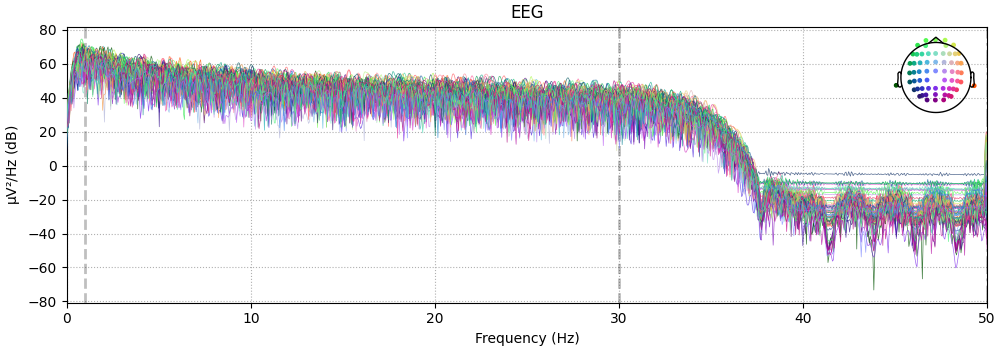

checkup plot showing reduced bandwidth of eeg signals


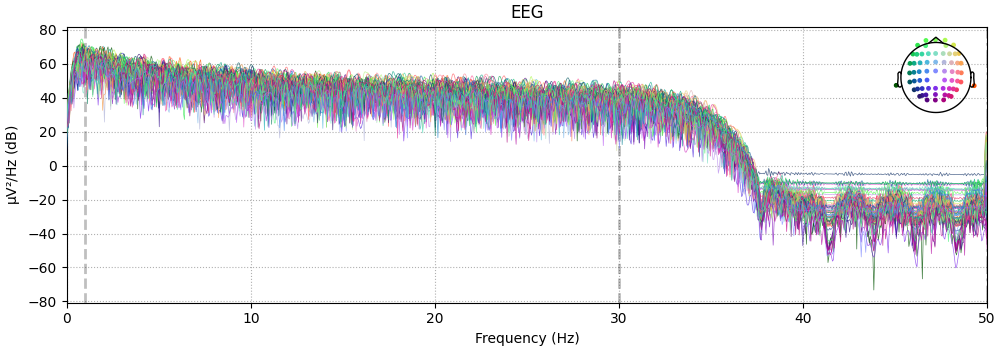

In [22]:
# checkup: print spectrum of original and filtered signals, print sample rate of new raw data file
curr_checkup_filename = f"{curr_bids_root}/derivatives/mne-bids-pipeline/sub-01/eeg/sub-01_task-SocialMemoryCuing_proc-filt_raw.fif"
curr_checkup_raw_filtered = mne.io.read_raw_fif(curr_checkup_filename, preload=True)
curr_checkup_raw_filtered.plot_psd()
print("checkup plot showing reduced bandwidth of eeg signals")

This checkup shows multiple results:

- For low frequencies, the power per frequency bin gets reduced by approximately 30-40 dB between 1 Hz and 0 Hz compared to constant power over frequency.
    - ⇒ The high pass filter seems to work.
- For high frequencies, the power per frequency bin gets reduced by about 60 dB compared to constant power over frequency in a third octave above the upper cutoff frequency at 30 Hz.
    - ⇒ The low pass filter seems to work.
- The 2d electrode position map (top right corner) seems to be somewhat valid.
    - ⇒ The electrode positions seem to be loaded correctly.
- The spectral power density seems to be similar for all electrodes for this subject.
    - ⇒ At first glance, the electrodes seem to have been mounted in a similar way. This could indicate a correct use of the EEG measurement technology by trained personal.

In [23]:
# checkup: print file name if the processed file exists
curr_subject_path = f"{curr_bids_root}/derivatives/mne-bids-pipeline/sub-01/eeg"
cmd.ls(curr_subject_path + "/sub-01_task-SocialMemoryCuing_proc-filt_raw.fif")

sub-01_task-SocialMemoryCuing_proc-filt_raw.fif


The file seems to exist. This indicates a correctly downloaded and extracted dataset at the expected path.

### Pre-processing: Split Signal to Epochs

In the next step, the signal gets split to epochs per subject.
This extraction is followed by the plot of all epochs of an example subject.

The epochs start one second before the cue object appears, and end them seven seconds later.
Therefore, the time interval is -1.0 to 6.0 seconds relative to the cue appearance.

The epochs contain multiple time frames:

- The baseline of 1 second (-1s to 0s),
- the cue pointing downwards (0s to 1.5s),
- the cue shifting upwards (1.5s to 2s),
- the cue "looking" at the subject directly (2s to 3s),
- the cue shifting left or right (3s to 3.5s), and
- the memory targets being shown (3.5s to 4s).

Since the content of these two seconds are not relevant for the main research question, they are removed from the interval:

- maintenance interval (4s to 5s), and
- showing of the location target to the subject (5s to 6s)

This results in the shortened interval of 5 seconds of -1 second to +4 seconds relative to the cue object appearance.
In addition to better focus on the more relevant data, the shortened duration should reduce the processing time by two in seven parts. This equals an expected increased processing speed by 28.6 % based on the number of to-be-processed samples.

In [24]:
curr_steps = "preprocessing/_05_make_epochs"
if curr_steps in STEPS_TO_RUN and STEPS_TO_RUN[curr_steps]:
    !mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│22:43:31│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│22:43:31│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│22:43:31│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_05_make_epochs ───────────────────────────────────────
│22:43:33│ ⏳️ sub-01 Loading filtered raw data from sub-01_task-SocialMemoryCuing_proc-filt_raw.fif
│22:43:33│ ⏳️ sub-01 Creating task-related epochs …
│22:43:33│ ⏳️ sub-07 Loading filtered raw data from sub-07_task-SocialMemoryCuing_proc-filt_raw.fif
│22:43:33│ ⏳️ sub-02 Loading filtered raw data from sub-02_task-SocialMemoryCuing_proc-filt_raw.fif
│22:43:33│ ⏳️ sub-06 Loading filtered raw data from sub-06_task-SocialMemoryCuing_proc-

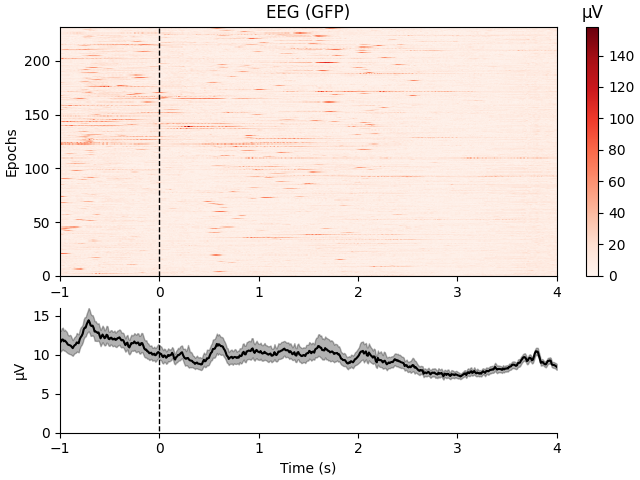

[<Figure size 640x480 with 3 Axes>]

In [25]:
# checkup: plot epochs
curr_checkup_epochs = mne.read_epochs(f"{curr_subject_path}/sub-01_task-SocialMemoryCuing_epo.fif")
mne.viz.plot_epochs_image(curr_checkup_epochs)

This checkup plot shows the amplitude in μV per epoch over time.
Here, increased activity is visible around -1 seconds, and at 0.5 to 3 seconds.
The roughly matching onset time of the activity and time frames with low amplitudes indicate a roughly correct epoching.

Next, we compare the detected number of epochs with the expected number of epochs recovered from the provided metadata.

In [26]:
import pandas
from mne.epochs import EpochsFIF

FILE_PATH_TEMPLATE = '{data}/derivatives/mne-bids-pipeline/sub-{sub}/eeg/sub-{sub}_task-SocialMemoryCuing_epo.fif'

METADATA_PATH_TEMPLATE = '{data}/derivatives/BehaviouralData_TableStudyVR/TableStudyRawdata/sub-{sub}/sub-{sub}__task-SocialMemoryCuing_{cue}_trial_results.csv'

SUBJECT_IDS = [ "01", "02", "03", "04",       "06", "07",       "09", "10",
                "11", "12", "13", "14", "15", "16", "17", "18", "19",
                "21", "22", "23", "24", "25", "26", "27", "28",       "30",
                "32", "33", "34", "35",             "38", "39", "40",
                "41",       "43", "44", "45", "46",       "48", "49", "50"]

CLEAN_SUBJECT_IDS = []

clean_subjects = 0

for sub_str in SUBJECT_IDS:
    path = FILE_PATH_TEMPLATE.format(data=cfg.bids_root, sub=sub_str)
    epochs: EpochsFIF = mne.read_epochs(path)

    detected_stick_length = len(epochs['sticks'].metadata)
    detected_avatar_length = len(epochs['avatar'].metadata)

    path_meta_avatar = METADATA_PATH_TEMPLATE.format(data=cfg.bids_root, sub=sub_str, cue="AVATAR")
    path_meta_stick = METADATA_PATH_TEMPLATE.format(data=cfg.bids_root, sub=sub_str, cue="STICK")

    meta_avatar_length = len(pandas.read_csv(path_meta_avatar))
    meta_stick_length = len(pandas.read_csv(path_meta_stick))
    
    isClean = False
    
    if meta_avatar_length - detected_avatar_length == 0 and meta_stick_length - detected_stick_length == 0:
        clean_subjects += 1
        CLEAN_SUBJECT_IDS.append(sub_str)
        isClean = True
    log.print("Subject {}: Lost Epochs: Avatar: {} Sticks: {}".format(sub_str,
                                                                  meta_avatar_length - detected_avatar_length,
                                                                  meta_stick_length - detected_stick_length), style=log.STYLE_TEXT_GREEN if isClean else log.STYLE_HIGHLIGHT_RED)

log.print(log.formatString("Total number of Subjects without missing Epochs:", style=log.STYLE_TEXT_BLUE), log.formatString(clean_subjects, style=[log.STYLE_BOLD, log.STYLE_TEXT_DARK_YELLOW]))

log.print(log.formatString("The following subjects are clean:", style=log.STYLE_TEXT_BLUE), log.formatString(*CLEAN_SUBJECT_IDS, style=log.STYLE_TEXT_DARK_YELLOW, sep=', '))

Subject 01: Lost Epochs: Avatar: 0 Sticks: 3
Subject 02: Lost Epochs: Avatar: 0 Sticks: 28
Subject 03: Lost Epochs: Avatar: 0 Sticks: 0
Subject 04: Lost Epochs: Avatar: 0 Sticks: 0
Subject 06: Lost Epochs: Avatar: 0 Sticks: 0
Subject 07: Lost Epochs: Avatar: 48 Sticks: 0
Subject 09: Lost Epochs: Avatar: 0 Sticks: 0
Subject 10: Lost Epochs: Avatar: 4 Sticks: 0
Subject 11: Lost Epochs: Avatar: 0 Sticks: 0
Subject 12: Lost Epochs: Avatar: 0 Sticks: 0
Subject 13: Lost Epochs: Avatar: 0 Sticks: 2
Subject 14: Lost Epochs: Avatar: 0 Sticks: 0
Subject 15: Lost Epochs: Avatar: 0 Sticks: 0
Subject 16: Lost Epochs: Avatar: 0 Sticks: 0
Subject 17: Lost Epochs: Avatar: 0 Sticks: 0
Subject 18: Lost Epochs: Avatar: 0 Sticks: 0
Subject 19: Lost Epochs: Avatar: 0 Sticks: 0
Subject 21: Lost Epochs: Avatar: 0 Sticks: 0
Subject 22: Lost Epochs: Avatar: 0 Sticks: 0
Subject 23: Lost Epochs: Avatar: 0 Sticks: 0
Subject 24: Lost Epochs: Avatar: 1 Sticks: 0
Subject 25: Lost Epochs: Avatar: 0 Sticks: 0
Subject 

As we can see, this results in only 29 subjects without any lost epochs. Lost epochs are somewhat problematic when applying the external metadata, since the locations of the lost epochs are not known, which may lead to misalignment between measured data and metadata. Unfortunately, mne-bids-pipeline does not seem to store the original timecodes of epochs in the metadata, therefore we can not match detected epochs with external metadata by timecode. If we needed more subjects, we could try to match epochs by their measurement values (or their deltas). Given the 500 floating point samples per epoch (because of subsampling to 100 hz and an epoch length of 5 seconds), this should provide a reasonably good chance to identify the epochs. But due to the limited time availabe, and 29 subjects still being enough for the purpose of this course, we decided not to implement this rather convoluted, computationally expensive epoch identification method.

In [27]:
from pandas import DataFrame
import pandas as pd

for sub_str in CLEAN_SUBJECT_IDS:
    path = FILE_PATH_TEMPLATE.format(data=cfg.bids_root, sub=sub_str)
    epochs: EpochsFIF = mne.read_epochs(path)

    detected_avatar_length = len(epochs['avatar'].metadata)
    

    path_meta_avatar = METADATA_PATH_TEMPLATE.format(data=cfg.bids_root, sub=sub_str, cue="AVATAR")
    path_meta_stick = METADATA_PATH_TEMPLATE.format(data=cfg.bids_root, sub=sub_str, cue="STICK")
    
    avatar_extern = pandas.read_csv(path_meta_avatar, index_col=False)
    stick_extern = pandas.read_csv(path_meta_stick, index_col=False)
    
    avatar_intern: DataFrame = epochs['avatar'].metadata
    stick_intern = epochs['sticks'].metadata
    
    idx_avatar = avatar_intern.index[0]
    idx_sticks = stick_intern.index[0]
    
    if idx_avatar < idx_sticks:
        extern = pd.concat([avatar_extern, stick_extern], axis=0, ignore_index=True)
    else:
        extern = pd.concat([stick_extern, avatar_extern], axis=0, ignore_index=True)
    
    metadata = pd.concat([epochs.metadata, extern], axis=1)
    
    epochs.metadata = metadata
    epochs.save(path, overwrite=True)

With this, we added the additional metadata provided for the study, and save the epochs with additional metadata for further processing using the pipeline. In order to verify that adding the metadata worked properly, we take a quick look at the saved epoch's metadata for subject 3.

In [28]:

from IPython.display import display

path = FILE_PATH_TEMPLATE.format(data=cfg.bids_root, sub="03")
epochs: EpochsFIF = mne.read_epochs(path)

frame: DataFrame = epochs.metadata
display(frame)

event_name       Impedance  avatar s3001 s3002 s3003 s3004 s3005 s3006  \
0       sticks  None      None     NaN  None  None  None  None  None  None   
1       sticks  None      None     NaN  None  None  None  None  None  None   
2       sticks  None      None     NaN  None  None  None  None  None  None   
3       sticks  None      None     NaN  None  None  None  None  None  None   
4       sticks  None      None     NaN  None  None  None  None  None  None   
..         ...   ...       ...     ...   ...   ...   ...   ...   ...   ...   
230     avatar  None      None     0.0  None  None  None  None  None  None   
231     avatar  None      None     0.0  None  None  None  None  None  None   
232     avatar  None      None     0.0  None  None  None  None  None  None   
233     avatar  None      None     0.0  None  None  None  None  None  None   
234     avatar  None      None     0.0  None  None  None  None  None  None   

     ...   Gaze ItemSide  SameLoc  Case      PersonShown         ProbeObject  \
0    ...   Left    Right      Yes  None             None   ProbePlate(Clone)   
1    ...   Left    Right      Yes  None             None  ProbeTeacup(Clone)   
2    ...   Left     Left       No  None             None  ProbeTeacup(Clone)   
3    ...   Left     Left       No  None             None  ProbeTeacup(Clone)   
4    ...  Right     Left       No  None             None  ProbeTeacup(Clone)   
..   ...    ...      ...      ...   ...              ...                 ...   
230  ...   Left     Left       No  None   MC04PrefabLeft  ProbeTeacup(Clone)   
231  ...   Left    Right      Yes  None   MC04PrefabLeft  ProbeTeapot(Clone)   
232  ...  Right     Left      Yes  None  FC01PrefabRight  ProbeTeapot(Clone)   
233  ...   Left     Left       No  None   MC04PrefabLeft  ProbeTeacup(Clone)   
234  ...  Right    Right       No  None  MC04PrefabRight  ProbeTeacup(Clone)   

    ResponseTimeLocation ResponseTimeStatus  \
0               1.242018           1.299345   
1               1.303890           1.488068   
2               2.125694           2.437103   
3               1.163239           2.412155   
4               1.750244           2.322540   
..                   ...                ...   
230             1.024780           0.936890   
231             1.074585           1.112305   
232             0.675537           1.811279   
233             0.975098           1.274414   
234             1.649902           0.962769   

                            QuestionAsked ConditionNumber  
0                     Was the bowl empty?               4  
1                     Was the bowl empty?               4  
2                 Was the teapot cracked?               1  
3        Was the teapot free from cracks?               1  
4    Did the croissant have a bite in it?               7  
..                                    ...             ...  
230        Did the cup have coffee in it?               1  
231             Was the coffee cup empty?               4  
232        Did the cup have coffee in it?               6  
233               Was the teapot cracked?               1  
234                   Was the bowl empty?               3  

[235 rows x 52 columns]

### Pre-processing: ICA

Running the ICA is split to three steps:

- component analysis
- component labelling (`good` vs. `bad`)
- signal cleaning

#### ICA: Analysis

For the analysis, per subject the algorithm selected in the configuration file gets run.
Here, extended infomax is selected, which follows peak to peak rejection (PTP) for better ICA results.
Since with low threshold the PTP does not return enough epochs, a high threshold of 400 μV is selected matching the default pipeline threshold.

For few subjects, the amplitudes are too high for this PTP threshold.
Here, two possibilities seem to be reachable:
Either few subjects need to get removed from the pipeline due to too high amplitudes resulting in removal of all epochs,
or the threshold needs to get increased to a value above all subjects amplitude.
To reach a good overall quality, the few subjects are removed from the pipeline.

More accurate PTP is later run on the ICA cleaned epoch signals.

The analysis is followed by a checkup plot of unlabelled components.

In [29]:
curr_steps = "preprocessing/_06a_run_ica"
if curr_steps in STEPS_TO_RUN and STEPS_TO_RUN[curr_steps]:
    !mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│22:44:49│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│22:44:49│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│22:44:49│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_06a_run_ica ──────────────────────────────────────────
│22:44:50│ ⏳️ sub-02 Loading filtered raw data from sub-02_task-SocialMemoryCuing_proc-filt_raw
│22:44:50│ ⏳️ sub-01 Loading filtered raw data from sub-01_task-SocialMemoryCuing_proc-filt_raw
│22:44:50│ ⏳️ sub-03 Loading filtered raw data from sub-03_task-SocialMemoryCuing_proc-filt_raw
│22:44:50│ ⏳️ sub-06 Loading filtered raw data from sub-06_task-SocialMemoryCuing_proc-filt_raw
│22:44:50│ ⏳️ sub-02 No ECG or magnetometer channels ar

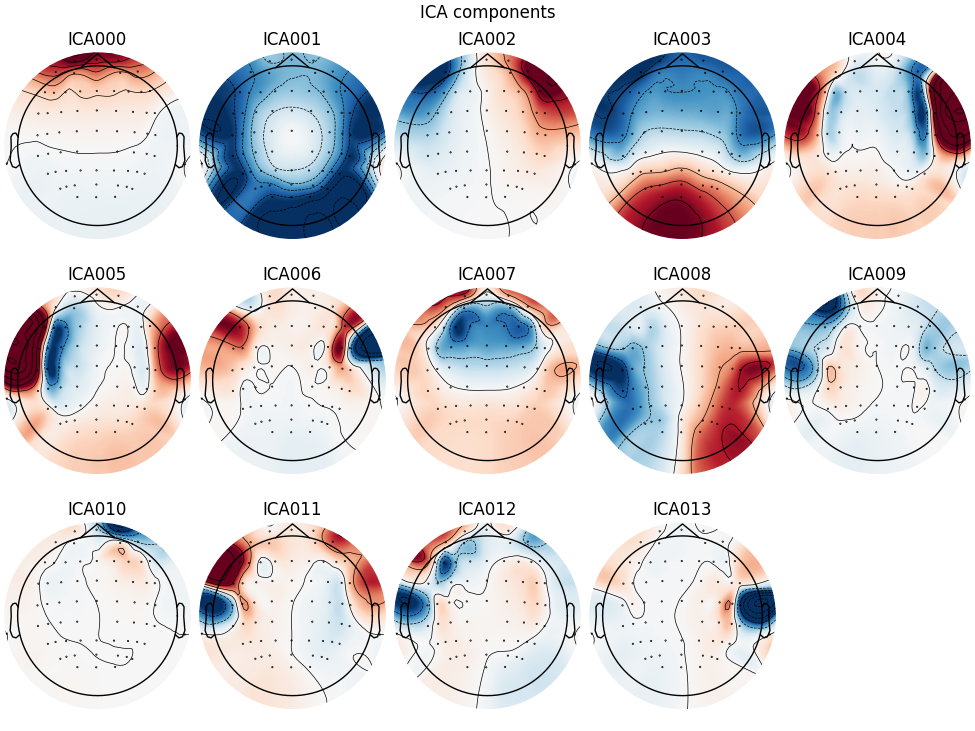

checkup: ICA component plots of the selected subject


In [30]:
# checkup: plot ica components
curr_checkup_ica = mne.preprocessing.read_ica(f"{curr_subject_path}/sub-01_task-SocialMemoryCuing_ica.fif")
curr_checkup_ica.apply(curr_checkup_raw_filtered)
curr_checkup_ica.plot_components(inst=curr_checkup_raw_filtered)
print("checkup: ICA component plots of the selected subject")

#### ICA: Labelling

For automatic labelling of the components, the ICA label algorithms provided in the MNE framework get applied.
The verbose version of the custom functions output is returned by this custom function.
This is is followed by the content of a single subjects updated component label file.

Components labelled as `brain` or `other` are kept.
These labels usually indicate, there are no or too few information for excluding the component.

Components labelled differently get marked as `bad` in the `*.tsv` file.
Examples for such labels are muscle artifact, eye blink, and channel noise.
The components labelled as `bad` are going to be excluded in the next step.

In [31]:
curr_steps = "preprocessing_apply_icalabel"
if curr_steps in STEPS_TO_RUN and STEPS_TO_RUN[curr_steps]:
    ih.update_ica_labels(cfg=cfg, do_print_verbose=True)



SUBJECT: 01
<ICA | epochs decomposition, method: infomax (fit in 3000 iterations on 106212 samples), 14 ICA components (63 PCA components available), channel types: eeg, no sources marked for exclusion>

resulting predictions: [0.8529084  0.78006613 0.9980018  0.83930933 0.28092322 0.54916686
 0.4785122  0.5192793  0.9846735  0.5491156  0.30257168 0.74395365
 0.49060318 0.36486763]

resulting labels:      ['eye blink', 'brain', 'eye blink', 'brain', 'eye blink', 'brain', 'other', 'eye blink', 'brain', 'brain', 'other', 'brain', 'other', 'brain']

old tsv file content:
    component type            description status  status_description
0           0  ica  Independent Component   good                 NaN
1           1  ica  Independent Component   good                 NaN
2           2  ica  Independent Component   good                 NaN
3           3  ica  Independent Component   good                 NaN
4           4  ica  Independent Component   good                 NaN
5        

In [32]:
# checkup: print list of components given in updated …_proc-ica+components.tsv file
#!cat "{curr_subject_path}/sub-01_task-SocialMemoryCuing_proc-ica_components.tsv"
cmd.cat(curr_subject_path + "/sub-01_task-SocialMemoryCuing_proc-ica_components.tsv")
# This file should contain a status like "bad" for eye blinks, or "good" for brain activity, as it is indicated above and visible in the ICA component plots.

component	type	description	status	status_description

0	ica	Independent Component	bad	

1	ica	Independent Component	good	

2	ica	Independent Component	bad	

3	ica	Independent Component	good	

4	ica	Independent Component	bad	

5	ica	Independent Component	good	

6	ica	Independent Component	good	

7	ica	Independent Component	bad	

8	ica	Independent Component	good	

9	ica	Independent Component	good	

10	ica	Independent Component	good	

11	ica	Independent Component	good	

12	ica	Independent Component	good	

13	ica	Independent Component	good	



This checkup prints the components of a subject with status in {`good`, `bad`}.
Since both labels are given, while the initial setup contains only `good` for all commponents, the ICA label software seems to work.

#### ICA: Cleaning
Based on the component labels, the signals of the corresponding subject get cleaned.

The resulting epoch signals get plotted in comparison to the not-ICA-cleaned epoch signals as checkup.
The amplitude of the epoch signals is visualised based on the colourbar on the right hand side.
This colourbar is independent per plot.
Therefore, the scale should be kept in mind while comparing versions.

In [33]:
curr_steps = "preprocessing/_07a_apply_ica"
if curr_steps in STEPS_TO_RUN and STEPS_TO_RUN[curr_steps]:
    !mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│22:50:32│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│22:50:32│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│22:50:33│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_07a_apply_ica ────────────────────────────────────────
│22:50:34│ ⏳️ sub-06 Input: sub-06_task-SocialMemoryCuing_epo.fif
│22:50:34│ ⏳️ sub-02 Input: sub-02_task-SocialMemoryCuing_epo.fif
│22:50:34│ ⏳️ sub-02 Output: sub-02_task-SocialMemoryCuing_proc-ica_epo.fif
│22:50:34│ ⏳️ sub-06 Output: sub-06_task-SocialMemoryCuing_proc-ica_epo.fif
│22:50:34│ ⏳️ sub-01 Input: sub-01_task-SocialMemoryCuing_epo.fif
│22:50:34│ ⏳️ sub-01 Output: sub-01_task-SocialMemoryCuing_proc-ica_epo.fif
│22:50:34│ ⏳️

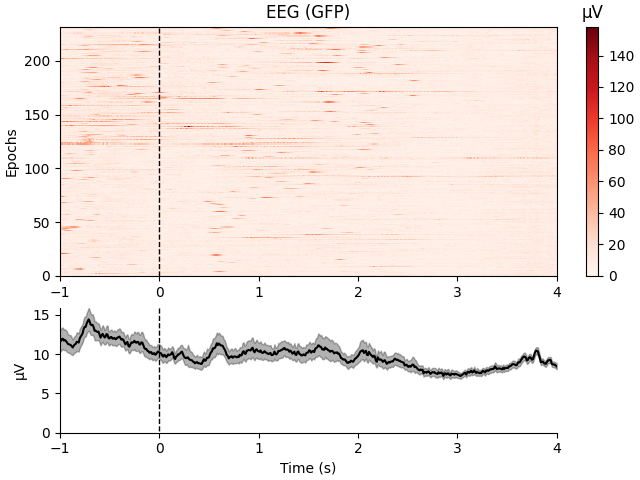

checkup: original (top) vs. ica-applied (bottom) epochs


In [34]:
# checkup: plot original (conventionally filtered) epochs
curr_checkup_epochs = mne.read_epochs(f"{curr_subject_path}/sub-01_task-SocialMemoryCuing_epo.fif")
mne.viz.plot_epochs_image(curr_checkup_epochs)
print("checkup: original (top) vs. ica-applied (bottom) epochs")

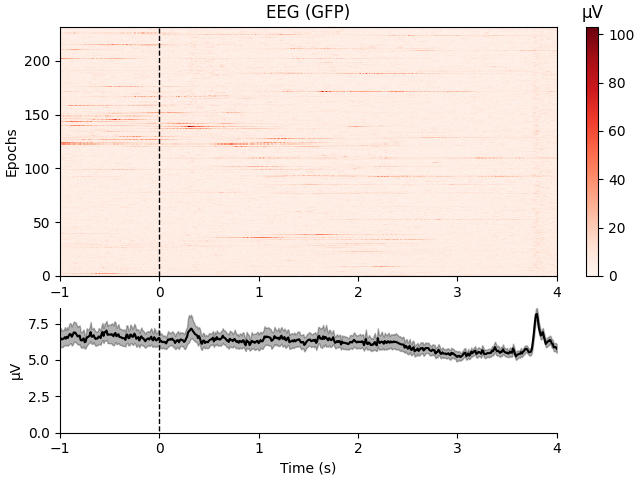

checkup: original (top) vs. ica-applied (bottom) epochs; Compare the scale in μV.


In [35]:
# checkup: plot ICA-corrected epochs
curr_checkup_epochs_ica = mne.read_epochs(f"{curr_subject_path}/sub-01_task-SocialMemoryCuing_proc-ica_epo.fif")
mne.viz.plot_epochs_image(curr_checkup_epochs_ica)
print("checkup: original (top) vs. ica-applied (bottom) epochs; Compare the scale in μV.")

### Pre-processing: Peak to Peak Rejection
The last step in the pre-processing is the peak to peak rejection.
This also is followed by plots comparing the original epoch signals after basic filtering to the ICA and PTP filtered epoch signals.

In [36]:
curr_steps = "preprocessing/_08_ptp_reject"
if curr_steps in STEPS_TO_RUN and STEPS_TO_RUN[curr_steps]:
    !mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│22:52:02│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│22:52:02│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│22:52:02│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ preprocessing/_08_ptp_reject ────────────────────────────────────────
│22:52:02│ ⏳️ sub-01 Input:  sub-01_task-SocialMemoryCuing_proc-ica_epo.fif
│22:52:02│ ⏳️ sub-01 Output: sub-01_task-SocialMemoryCuing_proc-clean_epo.fif
│22:52:02│ ⏳️ sub-01 Generating rejection thresholds using autoreject …
│22:52:06│ ⏳️ sub-01 Using PTP rejection thresholds: {'eeg': 0.0001316722246434394}
│22:52:06│ ⏳️ sub-01 Adding cleaned epochs to report.
│22:52:08│ ⏳️ sub-01 Adding config and sys info to report
│22:52:10│ ⏳️ sub

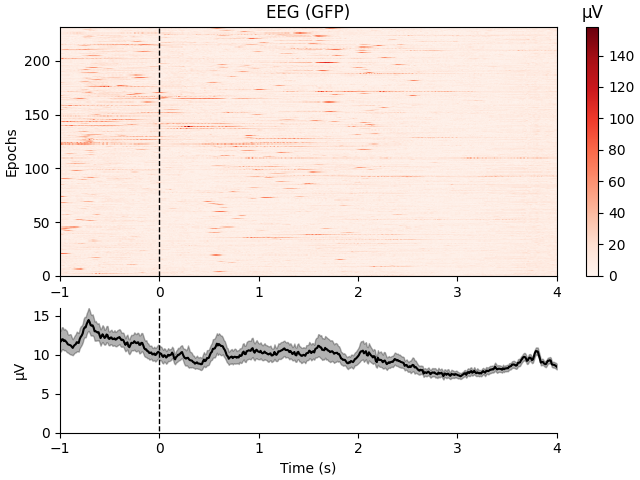

checkup: original epochs


In [37]:
# checkup: plot original (conventionally filtered) epochs
curr_checkup_epochs = mne.read_epochs(f"{curr_subject_path}/sub-01_task-SocialMemoryCuing_epo.fif")
mne.viz.plot_epochs_image(curr_checkup_epochs)
print("checkup: original epochs")

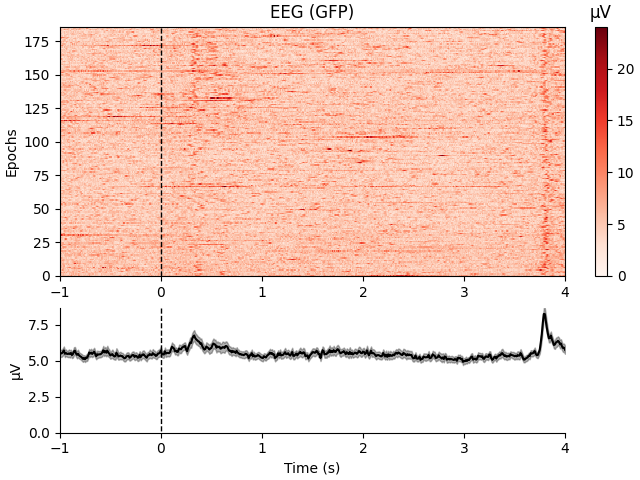

checkup: original (top) vs. cleaned epochs (bottom)


In [38]:
# checkup: plot cleaned epochs
curr_checkup_epochs_ptp = mne.read_epochs(f"{curr_subject_path}/sub-01_task-SocialMemoryCuing_proc-clean_epo.fif")
mne.viz.plot_epochs_image(curr_checkup_epochs_ptp)
print("checkup: original (top) vs. cleaned epochs (bottom)")

## Analysis
The pre-processing steps get followed by the analysis steps.

### Analysis: Sensor
Some plots including topography plot and power per electrode position/epoch/time are given by the separate notebook `more_visuals.ipynb`.

The topography plot indicates high amplitudes located in the front of the head.
For other regions, the absolute value of the energy seems to be lower.

In the power over time plot per electrode, increased power is visible for several time frames. This is visible through the little or missing change over multiple epochs.

In [ ]:
curr_steps = "sensor"
if curr_steps in STEPS_TO_RUN and STEPS_TO_RUN[curr_steps]:
    !mne_bids_pipeline --config {config_path} --steps {curr_steps}

┌────────┬ Welcome aboard MNE-BIDS-Pipeline! 👋 ────────────────────────────────
│22:54:57│ 📝 Using configuration: ./mne-bids/config/mne-bids-pipeline.py
└────────┴ 
┌────────┬ init/_01_init_derivatives_dir ───────────────────────────────────────
│22:54:57│ ✅ Output directories already exist …
└────────┴ done (1s)
┌────────┬ init/_02_find_empty_room ────────────────────────────────────────────
│22:54:57│ ⏩ Skipping, empty-room data only relevant for MEG …
└────────┴ done (1s)
┌────────┬ sensor/_01_make_evoked ──────────────────────────────────────────────
│22:54:58│ ⏳️ sub-01 Input: sub-01_task-SocialMemoryCuing_proc-clean_epo.fif
│22:54:58│ ⏳️ sub-01 Output: sub-01_task-SocialMemoryCuing_ave.fif
│22:54:58│ ⏳️ sub-03 Input: sub-03_task-SocialMemoryCuing_proc-clean_epo.fif
│22:54:58│ ⏳️ sub-04 Input: sub-04_task-SocialMemoryCuing_proc-clean_epo.fif
│22:54:58│ ⏳️ sub-03 Output: sub-03_task-SocialMemoryCuing_ave.fif
│22:54:58│ ⏳️ sub-04 Output: sub-04_task-SocialMemoryCuing_ave.fif
│22:54:

Another short test is printing the average Receiver Operating Characteristic Area Under the Curve (ROC AUC) results file content.
This checkup returns headings and values.

Since the content gets printed, the matching file for average ROC AUC output is known to exist.

In [ ]:
cmd.cat("./data/ds003702/derivatives/mne-bids-pipeline/sub-01/eeg/sub-01_task-SocialMemoryCuing_proc-avatar+sticks+FullEpochs+rocauc_decoding.tsv")

In order to also include the validity of the cue,
we modified the time-frequency conditions for the pipeline to also include groups seperated by their validity.
Due to MNE-Bids apparently not supporting manual labeling of epochs,
we also included the queries needed to get all permutations of valid and invalid cues.
This results in somewhat funny looking labels in the final report, but has no apparent drawbacks otherwise.

### Analysis: Source Space Analysis

In [ ]:
curr_steps = "source"
if curr_steps in STEPS_TO_RUN and STEPS_TO_RUN[curr_steps]:
    !mne_bids_pipeline --config {config_path} --steps {curr_steps}

In order to view all of the results, please view the full reports generated by the mne-bids pipeline. 

## Files per Step

To allow for additional investigation on the processed signals, the following list contains the exported files per step for the first subject.
These file names shall also help to interprete the check ups performed by printing file names of existing files.

- `preprocessing/_01_data_quality`
    ```
    sub-01_task-SocialMemoryCuing_report.h5
    sub-01_task-SocialMemoryCuing_report.h5.lock
    sub-01_task-SocialMemoryCuing_report.html
    ```
- `preprocessing/_04_frequency_filter`
    ```
    sub-01_task-SocialMemoryCuing_proc-filt_raw.fif
    ```
- `preprocessing/_05_make_epochs`
    ```
    sub-01_task-SocialMemoryCuing_epo.fif
    ```
- `preprocessing/_06a_run_ica`

    ```
    sub-01_task-SocialMemoryCuing_ica.fif
    sub-01_task-SocialMemoryCuing_proc-ica_components.tsv
    sub-01_task-SocialMemoryCuing_proc-ica+components_report.html
    ```
- ica labelling: no new file (just changes of `*.tsv` file)
- `preprocessing/_07a_apply_ica`
    ```
    sub-01_task-SocialMemoryCuing_proc-ica_epo.fif
    sub-01_task-SocialMemoryCuing_proc-ica_report.html
    ```
- `preprocessing/_08_ptp_reject`
    ```
    sub-01_task-SocialMemoryCuing_proc-clean_epo.fif
    ```
- `sensor`
    ```
    sub-01_task-SocialMemoryCuing_ave.fif  # average data

    # decoding analysis results related to ROC AUC (Receiver Operating Characteristic Area Under the Curve) metric, Matlab and tab separated file versions:
    sub-01_task-SocialMemoryCuing_proc-avatar+sticks+FullEpochs+rocauc_decoding.mat
    sub-01_task-SocialMemoryCuing_proc-avatar+sticks+FullEpochs+rocauc_decoding.tsv
    sub-01_task-SocialMemoryCuing_proc-avatar+sticks+TimeByTime+rocauc_decoding.mat
    sub-01_task-SocialMemoryCuing_proc-avatar+sticks+TimeByTime+rocauc_decoding.tsv

    # time frequency analysis results related to Time-Frequency Representation (TFR):
    sub-01_task-SocialMemoryCuing_itc+avatar+tfr.h5   # Inter-Trial Coherence (ITC)
    sub-01_task-SocialMemoryCuing_itc+sticks+tfr.h5
    sub-01_task-SocialMemoryCuing_power+avatar+tfr.h5 # power spectral density (PSD) 
    sub-01_task-SocialMemoryCuing_power+sticks+tfr.h5
    
    sub-01_task-SocialMemoryCuing_cov.fif
    sub-01_task-SocialMemoryCuing_proc-avatar+sticks+CSP+rocauc_decoding.xlsx
    ```
- `source`
    ```
    sub-01_task-SocialMemoryCuing_fwd.fif
    sub-01_task-SocialMemoryCuing_trans.fif
    ```


## Further Comparison

As a final check-up, we plot the power spectra for each subjects alpha and theta waves at two different time ranges during the experiment.

In [ ]:
SUBJECT_IDS = [ "01", "02", "03", "04",       "06", "07",       "09", "10",
                "11", "12", "13", "14", "15", "16", "17", "18", "19",      
                "21", "22", "23", "24", "25", "26", "27", "28",       "30",
                      "32", "33", "34", "35",             "38", "39", "40",
                "41",       "43", "44", "45", "46",       "48", "49", "50"]

data_path = cfg.bids_root
cues_list = ['avatar', 'sticks']
bands_list = ['alpha', 'theta']
time_ranges = [[2, 3], [3.6, 4]]
# '{data}/derivatives/mne-bids-pipeline/sub-{sub}/eeg/sub-{sub}_task-SocialMemoryCuing_power+{cue}+tfr.h5'

In [ ]:
from IPython.core.display import Markdown
from IPython.display import display, display_markdown

for subject_str in SUBJECT_IDS:
    display_markdown(Markdown("## Subject: {}".format(subject_str)))
    for idx_cue in range(len(cues_list)):
        for idx_time in range(len(time_ranges)):
            fig, axes = plt.subplots(1, 2)
    
            curr_filename_str = f"plot_power_sub-{subject_str}_{cues_list[idx_cue]}_" + \
                                f"{time_ranges[idx_time][0]:01.1f}-{time_ranges[idx_time][1]:01.1f}.png"
            
            for idx_band in range(len(bands_list)):
                
                #print(curr_filename_str)
                pwr = pp.plot_power(
                    config_path = config_path,
                    subject = subject_str,
                    cue = cues_list[idx_cue],
                    band = bands_list[idx_band],
                    time_range = time_ranges[idx_time],
                )
                fig_power = pwr.plot_topomap(ch_type='eeg', show=True, axes=axes[idx_band])
                axes[idx_band].set_title('{}: {} from {} s to {} s'.format(cues_list[idx_cue], bands_list[idx_band], *time_ranges[idx_time]))
            fig.set_size_inches(10, 5)
            fig.savefig(curr_filename_str)
            display(fig)
            plt.close(fig)

Finally, we attempt to replicate plots from the paper.

In [ ]:
from mne import EvokedArray

valid_epochs = []
invalid_epochs = []


FILE_PATH_TEMPLATE = '{data}/derivatives/mne-bids-pipeline/sub-{sub}/eeg/sub-{sub}_task-SocialMemoryCuing_proc-clean_epo.fif'

for sub_str in CLEAN_SUBJECT_IDS:
    path = FILE_PATH_TEMPLATE.format(data=cfg.bids_root, sub=sub_str)
    
    epochs: EpochsFIF = mne.read_epochs(path)
    
    incongruentAvg: EvokedArray = epochs["Congruence=='Incongruent' and event_name=='sticks'"]
    congruentAvg: EvokedArray = epochs["Congruence=='Congruent'"]
        
    valid_epochs.append(congruentAvg)
    invalid_epochs.append(incongruentAvg)

    

In [ ]:
from scipy.stats import ttest_ind

ELECTRODES = ['Fp1', 'Fpz', 'Fp2' , 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']

TIME = 'time'

def t_test(epochsA, epochsB, time_range=(-1, 4)):
    result = DataFrame()
    
    
    aframe: DataFrame = epochsA.to_data_frame()
    aframe = aframe[(min(time_range) <= aframe[TIME]) & (aframe[TIME] <= max(time_range))]
    bframe: DataFrame = epochsB.to_data_frame()
    bframe = bframe[(min(time_range) <= bframe[TIME]) & (bframe[TIME] <= max(time_range))]
    
    for electrode in ELECTRODES:
        result[electrode] = ttest_ind(aframe[electrode], bframe[electrode])
    
    return result


t_testresult2 = t_test(valid_epochs[0], invalid_epochs[1], time_range=(2.0, 3.0))
display_markdown(Markdown("## T-Test between Valid and Invalid cues, between 2 s and 3 s"))
display(t_testresult2)
    
t_testresult = t_test(valid_epochs[0], invalid_epochs[1], time_range=(3.6, 4.0))
display_markdown(Markdown("## T-Test between Valid and Invalid cues, between 3.6 s and 4 s"))
display(t_testresult)

Finally, we computed the two-sample t-test between valid and invalid cues for each electrode. In order to interpret the tables provided, the top row (with index 0) is the t-statistic and the bottom row (with index 1) is the p-value.

Overall, we think that our results match the results presented by Gregory et al. 